# More Data Cleaning -> Feature Engineering -> Sentiment Analysis
1) Determine the language of each transcript

2) Get runtime and rating info from IMDb 

3) Remove whitespace

4) Remove any unwanted characters

5) Split transcripts into sentences and words with NLTK and count them

6) Perform sentiment analysis with TextBlob

7) Count swear words

KDE plots are used throughout to make sure everything looks right. Quickly viewing a simple distribution can be a great indicator that the code and data are performing as expected.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

In [2]:
df = pd.read_csv('stand-up-data.csv')
df.head()

,title,date_posted,link,name,year,transcript
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start t..."
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th..."
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Thea..."
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over ...
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welco..."


### Use the langdetect library to id the languages of each transcript

In [3]:
from langdetect import detect

# Dectect language based on the first 500 characters and create a language column in the df
df['language'] = df.transcript.apply(lambda x: detect(x[:500]))

print(df.language.value_counts())
df.head()

en    322
it      7
es      1
Name: language, dtype: int64


,title,date_posted,link,name,year,transcript,language
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start t...",en
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Thea...",en
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over ...,en
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welco...",en


### Get runtime and rating info with an IMDb api
For the most part, only fully produced specials will have data on IMDb. Only 52 titles from our original set of 300+ were not found on IMDb.

In [4]:
import imdb

imdb = imdb.IMDb()

def get_imdb_info(titles):
    runtime = []
    rating = []
    count = -1
    errors = 0
    
    for i in titles:
        count += 1
        # Search the first 30 characters on IMDb
        result = imdb.search_movie(i[:30])
        try:
            mov = imdb.get_movie(result[0].movieID, info=['main'])
            runtime.append(int(mov.get('runtimes')[0]))
            rating.append(mov.get('rating'))
        except:
            runtime.append('')
            rating.append('')
            errors += 1
            # print(f'Error on index {count}, title: {i}') # Uncomment to investigate which titles were not found
    print(f'Total not found: {errors}')
    return pd.Series(runtime), pd.Series(rating)
    
runtime, rating = get_imdb_info(df.title)

df['runtime'] = runtime
df['rating'] = rating

# Replace empty values with NaN
df = df.replace(r'^\s*$', np.NaN, regex=True)

df.head()

Total not found: 52


,title,date_posted,link,name,year,transcript,language,runtime,rating
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start t...",en,67.0,6.1
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en,NaN,NaN
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Thea...",en,59.0,7.8
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over ...,en,60.0,7.2
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welco...",en,68.0,7.7


### Perform some simple visualization to make sure everything looks right

Mean: 67.92086330935251
SD: 15.019921901626384


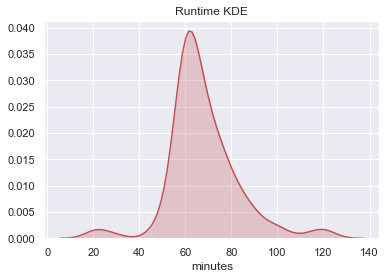

In [5]:
import numpy as np
import seaborn as sns; sns.set(color_codes=True)

# Stats and KDE plot for runtime of each performance
x = []
count = 0
for i in df.runtime:
    if (i > 0):
        count += 1
        x.append(int(i))
ax = sns.kdeplot(x, shade=True, color="r")   
ax.set_title('Runtime KDE')
ax.set(xlabel='minutes')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 7.337050359712229
SD: 0.8962920846805585


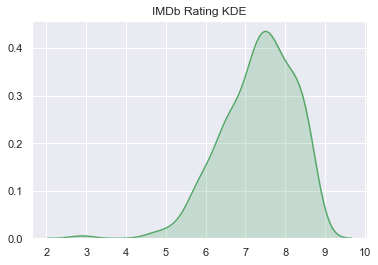

In [6]:
# Stats and KDE plot for IMDb rating of each performance
x = []
count = 0
for i in df.rating:
    if (i > 0):
        count += 1
        x.append(i)
ax = sns.kdeplot(x, shade=True, color="g")   
ax.set_title('IMDb Rating KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Clean text further by removing all extraneous characters and white space

In [7]:
# Collect all charcters to see which ones are present in the transcripts
chars = []
df.transcript.apply(lambda x: [chars.append(char) for char in x if char not in chars])

print(len(chars))
print(chars)

127
[' ', 'N', 'A', 'R', 'T', 'O', ':', 'L', 'a', 'd', 'i', 'e', 's', 'n', 'g', 't', 'l', 'm', ',', '’', 'r', 'h', 'D', 'o', 'S', 'C', 'I', 'V', 'P', 'u', '.', 'b', 'w', 'y', 'v', 'k', 'f', 'p', 'c', 'H', '!', 'B', 'W', '?', 'j', 'F', 'G', 'Y', 'K', 'U', 'E', '-', '–', 'x', 'q', 'z', 'M', 'J', '$', '%', 'X', 'Q', '—', '′', '″', 'ñ', 'Z', "'", '/', '\xa0', '‘', '£', '#', ']', '&', '*', ';', 'é', 'è', 'ú', 'ç', 'í', 'ö', 'ä', 'ô', 'Ç', '@', 'ü', 'Ü', 'ó', '¿', 'á', 'É', 'Ó', '×', '\\', '¡', '_', 'å', 'à', '®', 'ê', 'ù', 'Ã', 'ƒ', 'Â', 'º', '`', '+', 'Á', 'ì', 'È', 'ò', '¶', 'û', '♫', 'Ö', '¢', 'ﬂ', '♬', '\u200a', '»', '=', '\u200b', 'â', '~', '>']


In [8]:
# Remove all unwanted characters
remove = ['-', '–', '$', '%', '—', '‘', '′', '″', '/', '£', '#', ']', '&', '*', '@', '×', '\\', '¡', '_', '®', 'ƒ', 'º', '`', '+', '¶', '♫', '¢', 'ﬂ', '♬', '»', '=', '\u200b', 'â', '~', '>']
df.transcript = df.transcript.apply(lambda x: ''.join([char for char in x if char not in remove]))

In [9]:
import re

# Remove leading, trailing, and intermitent whitespace
print("With extra whitespace: ")
print(df.iloc[15].transcript[:100])
df.transcript = df.transcript.apply(lambda x: re.sub("\s+", " ", x).strip())
print("Without extra whitespace:")
print(df.iloc[15].transcript[:100])

With extra whitespace: 
  Fire  Fire    Man on fire  Fire  Fire  Fire  Man on fire  Yes.  Yes. All right. Yeah. All right. J
Without extra whitespace:
Fire Fire Man on fire Fire Fire Fire Man on fire Yes. Yes. All right. Yeah. All right. Just relax. W


### Create sentence and word tokens with NLTK for sentiment analysis and other statistics

In [10]:
# Tokenize sentences and words
from nltk.tokenize import sent_tokenize, word_tokenize

sentences = df.transcript.apply(lambda x: sent_tokenize(x))
words = df.transcript.apply(lambda x: word_tokenize(x))

print(sentences[7][10:15])
print(words[7][10:15])

['I uh I’ve been battling with my girlfriend a lot lately.', 'Um.', 'She loves to watch The Oprah Winfrey Show and I love to watch her watch The Oprah Show and then I wait for Oprah to say something that I don’t agree with and then I take it out on my girlfriend because I’m a jerk!', 'So Oprah brings out her first guest, right?', 'She gives her this huge intro.']
['in', '.', 'Please', 'welcome', 'back']


Mean: 901.9484848484849
SD: 429.6550065097769


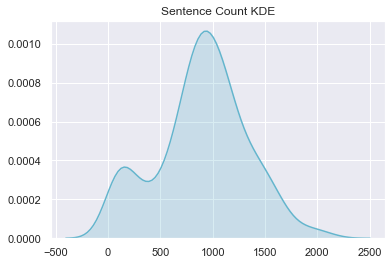

In [11]:
# Stats and KDE plot for sentence count
x = [len(x) for x in sentences]
ax = sns.kdeplot(x, shade=True, color="c")
ax.set_title('Sentence Count KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 10644.142424242424
SD: 4478.209398079624


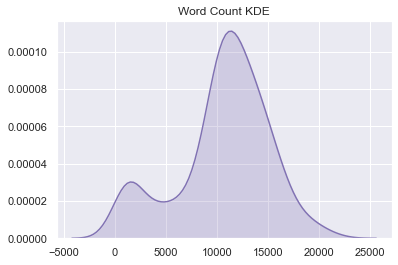

In [12]:
# Stats and KDE plot for word count
x = [len(x) for x in words]
ax = sns.kdeplot(x, shade=True, color="m")
ax.set_title('Word Count KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Perform sentiment analysis with TextBlob

In [13]:
# Sentiment analysis: Gather polarity and subjectivity values at the sentence and word levels
from textblob import TextBlob
from string import punctuation

def get_sentiment(series):
    pol = []
    sub = []
    for s in series:
        pol_per_comedian = []
        sub_per_comedian = []
        for item in s:
            item = item.lower()
            item = re.sub('\[.*?\]', '', item)
            item = re.sub('[%s]' % re.escape(punctuation), '', item)
            blob = TextBlob(item)
            pol_per_comedian.append(blob.polarity)
            sub_per_comedian.append(blob.subjectivity)
        pol.append(np.array(pol_per_comedian))
        sub.append(np.array(sub_per_comedian))
    pol_sub_dict = {'polarity': pol, 'subjectivity': sub}
    return pol_sub_dict

sent_pol_sub_dict = get_sentiment(sentences)
word_pol_sub_dict = get_sentiment(words)

df['sent_polarity'] = sent_pol_sub_dict['polarity']
df['sent_subjectivity'] = sent_pol_sub_dict['subjectivity']
df['word_polarity'] = word_pol_sub_dict['polarity']
df['word_subjectivity'] = word_pol_sub_dict['subjectivity']

df.head()

,title,date_posted,link,name,year,transcript,language,runtime,rating,sent_polarity,sent_subjectivity,word_polarity,word_subjectivity
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start tim...",en,67.0,6.1,"[0.0, -0.35714285714285715, 1.0, 0.28571428571...","[0.0, 0.7678571428571428, 1.0, 0.5357142857142...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en,NaN,NaN,"[0.8, 0.0, 0.0, 0.0, 0.26, 0.85, 0.8, 0.0, 0.0...","[0.9, 0.0, 0.0, 0.0, 0.26, 1.0, 0.75, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0, ..."
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Theatr...",en,59.0,7.8,"[0.2, 0.13636363636363635, 0.0, 0.0, -0.2, 0.1...","[0.5, 0.5, 0.0, 0.0, 0.8, 1.0, 0.6, 0.53571428...","[0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.1363636363636...","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, ..."
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over d...,en,60.0,7.2,"[0.4083333333333333, 0.8166666666666668, 0.45,...","[0.3333333333333333, 0.9666666666666667, 0.95,...","[0.0, 0.0, 0.0, 0.4333333333333333, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.7333333333333333, 0.0, 0.0, ..."
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welcom...",en,68.0,7.7,"[0.8, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, ...","[0.9, 0.0, 0.0, 0.06666666666666667, 0.0, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, ..."


In [14]:
df['word_count'] = words.apply(lambda x: len(x))
df['sent_count'] = sentences.apply(lambda x: len(x))
df['words_per_sentence'] = df.word_count / df.sent_count

df.head()

,title,date_posted,link,name,year,transcript,language,runtime,rating,sent_polarity,sent_subjectivity,word_polarity,word_subjectivity,word_count,sent_count,words_per_sentence
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start tim...",en,67.0,6.1,"[0.0, -0.35714285714285715, 1.0, 0.28571428571...","[0.0, 0.7678571428571428, 1.0, 0.5357142857142...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14989,1244,12.049035
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en,NaN,NaN,"[0.8, 0.0, 0.0, 0.0, 0.26, 0.85, 0.8, 0.0, 0.0...","[0.9, 0.0, 0.0, 0.0, 0.26, 1.0, 0.75, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0, ...",11391,917,12.422028
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Theatr...",en,59.0,7.8,"[0.2, 0.13636363636363635, 0.0, 0.0, -0.2, 0.1...","[0.5, 0.5, 0.0, 0.0, 0.8, 1.0, 0.6, 0.53571428...","[0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.1363636363636...","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, ...",7977,771,10.346304
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over d...,en,60.0,7.2,"[0.4083333333333333, 0.8166666666666668, 0.45,...","[0.3333333333333333, 0.9666666666666667, 0.95,...","[0.0, 0.0, 0.0, 0.4333333333333333, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.7333333333333333, 0.0, 0.0, ...",11642,1161,10.027562
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welcom...",en,68.0,7.7,"[0.8, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, ...","[0.9, 0.0, 0.0, 0.06666666666666667, 0.0, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, ...",15841,1623,9.760320


Mean: 0.027479232802095938
SD: 0.02863841597775358


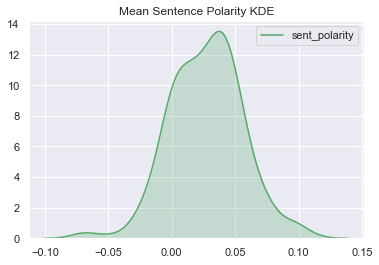

In [15]:
mean_sent_polarity = df.sent_polarity.apply(lambda x: x.mean())

ax = sns.kdeplot(mean_sent_polarity, shade=True, color="g")
ax.set_title('Mean Sentence Polarity KDE')
mean = mean_sent_polarity.mean()
sd = mean_sent_polarity.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 12.400557239269235
SD: 3.061013110827249


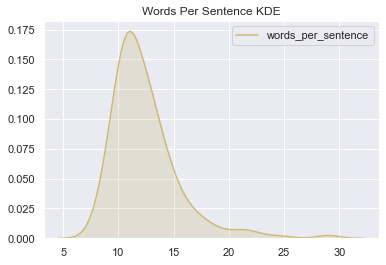

In [16]:
ax = sns.kdeplot(df.words_per_sentence, shade=True, color="y")
ax.set_title('Words Per Sentence KDE')
mean = df.words_per_sentence.mean()
sd = df.words_per_sentence.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

### Count the number of times an 'F' or 'S' word is used

In [18]:
def get_swear_counts(input_list, swear_list):
    swears = 0
    for word in input_list:
        if word.lower()in swear_list:
            swears += 1
    return swears

f_words = ['fuck', 'fucking', 'fuckin', 'fucker', 'fucka']
s_words = ['shit', 'shitter', 'shitting', 'shite']

df['f_words'] = words.apply(lambda x: get_swear_counts(x, f_words))
df['s_words'] = words.apply(lambda x: get_swear_counts(x, s_words))

df.head()

,title,date_posted,link,name,year,transcript,language,runtime,rating,sent_polarity,sent_subjectivity,word_polarity,word_subjectivity,word_count,sent_count,words_per_sentence,f_words,s_words
0,Russell Peters: Deported,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/russe...,Russell Peters,2020.0,"NARRATOR: Ladies and gentlemen, it’s start tim...",en,67.0,6.1,"[0.0, -0.35714285714285715, 1.0, 0.28571428571...","[0.0, 0.7678571428571428, 1.0, 0.5357142857142...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14989,1244,12.049035,63,27
1,Jimmy O. Yang: Good Deal,"May 10th, 2020",https://scrapsfromtheloft.com/2020/05/10/jimmy...,Jimmy O. Yang,2020.0,"ANNOUNCER: Ladies and gentlemen, welcome to th...",en,NaN,NaN,"[0.8, 0.0, 0.0, 0.0, 0.26, 0.85, 0.8, 0.0, 0.0...","[0.9, 0.0, 0.0, 0.0, 0.26, 1.0, 0.75, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0, ...",11391,917,12.422028,26,37
2,Jo Koy: Lights Out,"May 9th, 2020",https://scrapsfromtheloft.com/2020/05/09/jo-ko...,Jo Koy,2012.0,"L.A., are you ready? Live from the Alex Theatr...",en,59.0,7.8,"[0.2, 0.13636363636363635, 0.0, 0.0, -0.2, 0.1...","[0.5, 0.5, 0.0, 0.0, 0.8, 1.0, 0.6, 0.53571428...","[0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.1363636363636...","[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, ...",7977,771,10.346304,45,34
3,Lee Mack: Going Out Live,"May 8th, 2020",https://scrapsfromtheloft.com/2020/05/08/lee-m...,Lee Mack,2010.0,This programme contains strong language Over d...,en,60.0,7.2,"[0.4083333333333333, 0.8166666666666668, 0.45,...","[0.3333333333333333, 0.9666666666666667, 0.95,...","[0.0, 0.0, 0.0, 0.4333333333333333, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.7333333333333333, 0.0, 0.0, ...",11642,1161,10.027562,32,4
4,Lee Mack: Live,"May 7th, 2020",https://scrapsfromtheloft.com/2020/05/07/lee-m...,Lee Mack,2007.0,"PRESENTER: Ladies and gentlemen, please welcom...",en,68.0,7.7,"[0.8, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, ...","[0.9, 0.0, 0.0, 0.06666666666666667, 0.0, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, ...",15841,1623,9.760320,98,19


Mean: 41.92424242424242
SD: 45.45845847576358


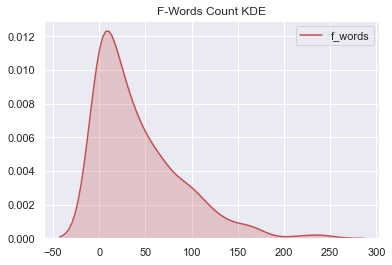

In [19]:
ax = sns.kdeplot(df.f_words, shade=True, color="r")
ax.set_title('F-Words Count KDE')
mean = df.f_words.mean()
sd = df.f_words.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 22.60909090909091
SD: 28.986034407286613


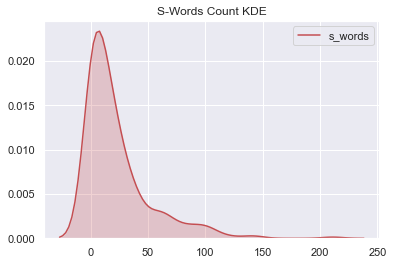

In [20]:
ax = sns.kdeplot(df.s_words, shade=True, color="r")
ax.set_title('S-Words Count KDE')
mean = df.s_words.mean()
sd = df.s_words.std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               330 non-null    object 
 1   date_posted         330 non-null    object 
 2   link                330 non-null    object 
 3   name                326 non-null    object 
 4   year                313 non-null    float64
 5   transcript          330 non-null    object 
 6   language            330 non-null    object 
 7   runtime             278 non-null    float64
 8   rating              278 non-null    float64
 9   sent_polarity       330 non-null    object 
 10  sent_subjectivity   330 non-null    object 
 11  word_polarity       330 non-null    object 
 12  word_subjectivity   330 non-null    object 
 13  word_count          330 non-null    int64  
 14  sent_count          330 non-null    int64  
 15  words_per_sentence  330 non-null    float64
 16  f_words 

### Save data into a csv file for more analysis later on

In [22]:
# Save DataFrame to the current drectory
df.to_csv(r'./stand-up-data-cleaned.csv', index=False)